In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm
import seaborn as sns

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"

# Output path info
OUTDIR = "pdfs/"

# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Manually remove problematic families. TODO add this instead to the QC script
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

In [27]:
# Load expression data
coldata = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/columns_metadata.csv")
rowdata = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/rows_metadata.csv")
brainspan = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/expression_matrix.csv",
                  names=coldata["column_num"])
brainspan.index = list(rowdata["gene_symbol"])

# Load per-locus mutation info
LOCFILE = "/storage/mgymrek/ssc-denovos/denovos_GW_priors_Jan20/SSC_allphases_011720_denovos_GW_priors_Aug20.locus_stats_rmoutlierfams.tab"
data = pd.read_csv(LOCFILE, delim_whitespace=True)

# Convert locus file to hg19
coords = pd.read_csv("/storage/mgymrek/ssc-denovos/for-gtex/ssc_hg19_coords.bed", sep="\t",
                     names=["chrom1","pos_hg19","end_hg19","coords_hg38"])
coords = coords[coords["chrom1"].apply(lambda x: "X" not in x and "Y" not in x and "_" not in x)]
coords["chrom"] = coords["chrom1"].apply(lambda x: GetChrom(x))
coords["pos"] = coords["coords_hg38"].apply(lambda x: int(x.split(":")[1]))
data = pd.merge(data, coords[["chrom","pos","pos_hg19"]], on=["chrom","pos"])

In [28]:
# Get case-only and ctrl-only genes
def GetGene(x):
    if x["FEATURE-CODING"]>0: return x["gene-coding"]
    if x["FEATURE-UTR5"]>0: return x["gene-utr5"]
    if x["FEATURE-UTR3"]>0: return x["gene-utr3"]
    else: return x["TSS_GENE"]

usecols = (adata["FEATURE-PROMOTER5kb"]>0) | (adata["FEATURE-CODING"]>0) | (adata["FEATURE-UTR5"]>0) #| (adata["FEATURE-FETALBRAINTSS"]>0)
adata["gene"] = adata.apply(GetGene, 1)
genes_cases = set(adata[(adata["phenotype"]==2) & usecols]["gene"]).intersection(set(rowdata["gene_symbol"]))
genes_ctrls = set(adata[(adata["phenotype"]==1) & usecols]["gene"]).intersection(set(rowdata["gene_symbol"]))
both = genes_cases.intersection(genes_ctrls)
genes_cases = genes_cases.difference(both)
genes_ctrls = genes_ctrls.difference(both)

# Get expression for each
means_cases = []
means_ctrls = []
medians_cases = []
medians_ctrls = []
pvals = []

for i in range(1, (brainspan.shape[1])+1):
    cols = i
    mean_ctrl = np.mean(brainspan.loc[genes_ctrls,cols])
    mean_case = np.mean(brainspan.loc[genes_cases,cols])
    means_cases.append(mean_case)
    means_ctrls.append(mean_ctrl)
    median_ctrl = np.median(brainspan.loc[genes_ctrls,cols])
    median_case = np.median(brainspan.loc[genes_cases,cols])
    medians_cases.append(median_case)
    medians_ctrls.append(median_ctrl)
    expr_ctrl = np.log(brainspan.loc[genes_ctrls,cols]+0.01)
    expr_case = np.log(brainspan.loc[genes_cases,cols]+0.01)
    pvals.append(scipy.stats.ks_2samp(expr_ctrl, expr_case, alternative="greater")[1])
    
coldata["mean_case"] = means_cases
coldata["mean_ctrl"] = means_ctrls
coldata["median_case"] = medians_cases
coldata["median_ctrl"] = medians_ctrls
coldata["pval"] = pvals

In [29]:
timepoints = ["8 pcw", "9 pcw", "13 pcw", "16 pcw", "21 pcw", "24 pcw", "37 pcw",
             "4 mos", "10 mos", "3 yrs", "8 yrs","18 yrs", "36 yrs", "37 yrs"]
structures = sorted(set(coldata["structure_acronym"]))
structures = [item for item in structures if item not in ["CB","LGE","CGE","URL","DTH","M1C-S1C","Ocx",
                                                         "MGE","PCx","TCx"]]

fcdata = np.zeros((len(structures), len(timepoints)))
pvaldata = np.zeros((len(structures), len(timepoints)))

coldata["FC"] = coldata.apply(lambda x: x["median_case"]/x["median_ctrl"], 1)

for i in range(len(structures)):
    for j in range(len(timepoints)):
        plotdata = coldata[(coldata["structure_acronym"]==structures[i]) & 
                           (coldata["gender"]=="M") &
                           (coldata["age"] == timepoints[j])]
        if plotdata.shape[0] == 0:
            fcdata[i,j] = np.nan
            pvaldata[i,j] = np.nan
            continue
        pval = np.min(plotdata["pval"])
        print(pval)
        pvaldata[i,j] = -1*np.log10(pval)
        fcdata[i,j] = np.max(plotdata["FC"])
    

0.008245933068729786
0.018422522923422075
0.039040226333495104
0.09453446217985337
0.017845525959747664
0.022810389121792358
0.03835438521289117
0.03774392998026488
0.022810389121792358
0.02298676781840411
0.018899828739808024
0.015395226462763792
0.0016410268045965607
0.012348304005783196
0.019422912252226074
0.04065874627216735
0.02043384725847855
0.007312701483082113
0.026451438526678667
0.0029720758976261303
0.029095643747288742
0.013994094784443432
0.03024759707327949
0.018934023140615933
0.056822615088924486
0.024156798196534206
0.0055389857109951
0.010035813318824015
0.013159810716085756
0.01635201673097456
0.02429723738381592
0.014632869268184034
0.013627618479568523
0.04947597335335572
0.000807218313790257
0.012920018860297902
0.0032601370642538602
0.052414701836994246
0.020755706735481154
0.06516725991661217
0.042937390575001545
0.10765276995953248
0.01863646178175699
0.016782037443288766
0.0320202281559036
0.07341231104292578
0.02079343742703261
0.03249096970839639
0.0044135

8 pcw
(59.68682861372412, 5.909273570778429e-07)
9 pcw
(50.2580234309247, 2.392714827216367e-07)
13 pcw
(129.0912199377901, 6.278198857545824e-15)
16 pcw
(110.63040567253762, 1.3699636951922735e-10)
21 pcw
(108.20572612312728, 2.27624539842126e-11)
24 pcw
(105.62319217966686, 8.502030392374363e-10)
37 pcw
(95.78348699107833, 2.7921625116998487e-08)
4 mos
(101.93458055028877, 3.1973020445830563e-09)
10 mos
(65.61506634656945, 9.309916603609527e-07)
3 yrs
(108.17402711395131, 2.304019560160198e-11)
8 yrs
(100.04901853552603, 6.248602524327828e-09)
18 yrs
(98.06131339021726, 2.690884136800547e-10)
36 yrs
(90.69066859276319, 1.6079445335151976e-07)
37 yrs
(98.095547701582, 1.2444281097788667e-08)


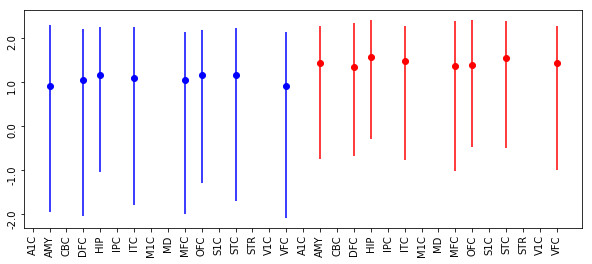

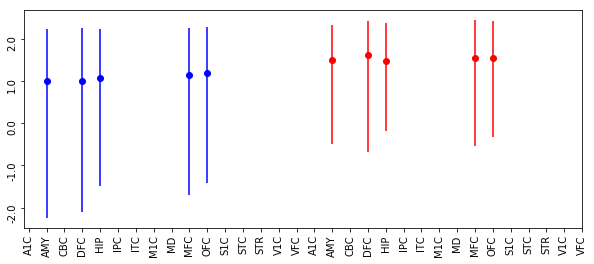

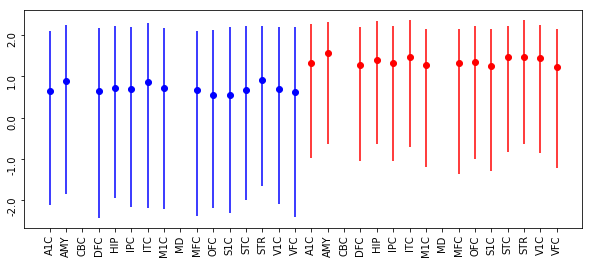

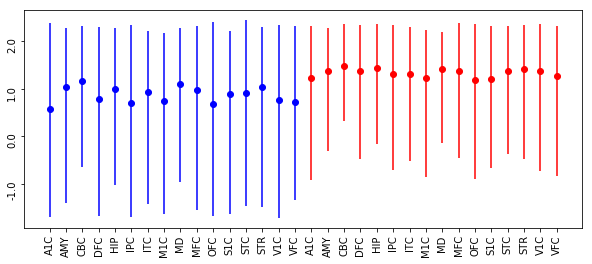

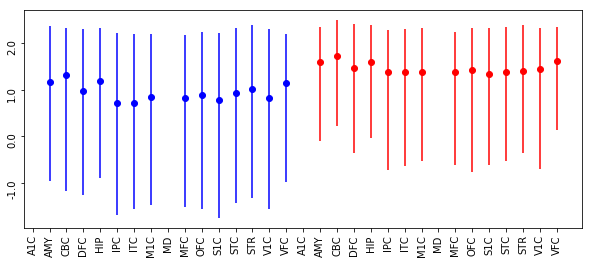

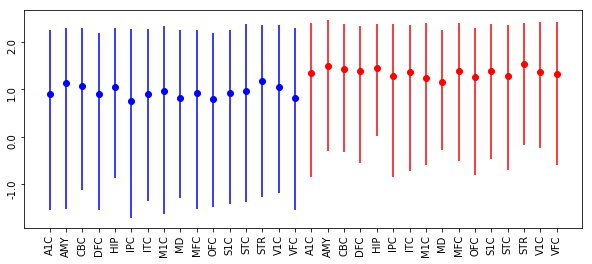

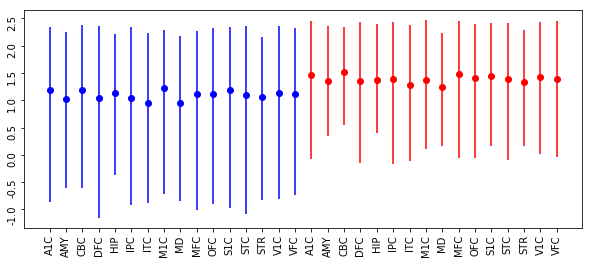

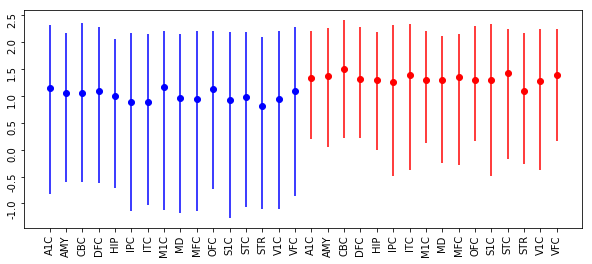

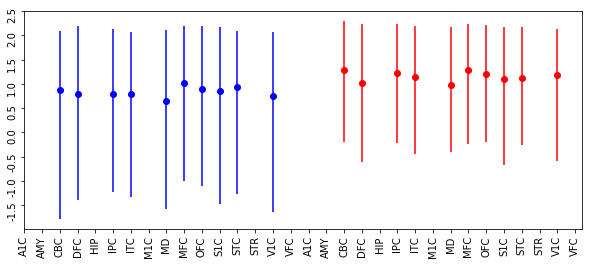

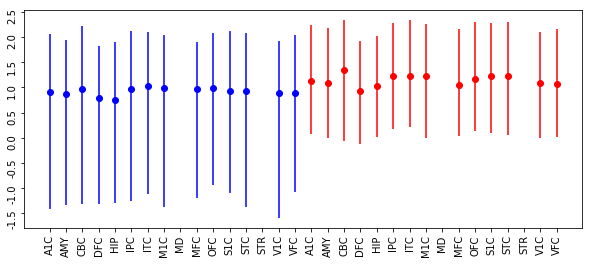

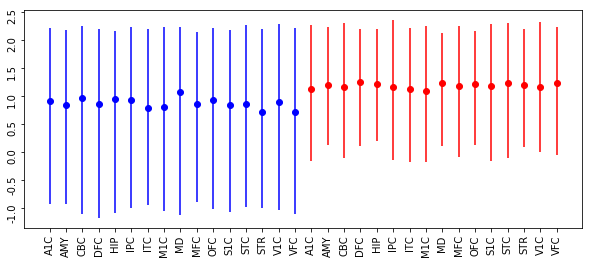

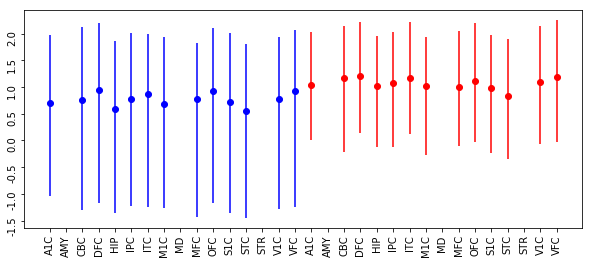

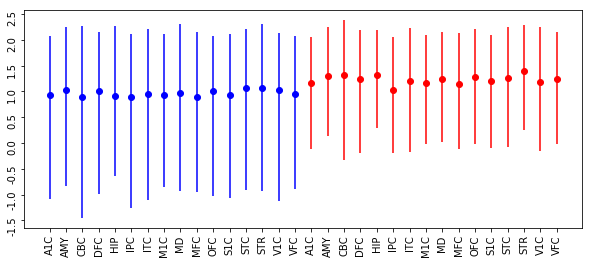

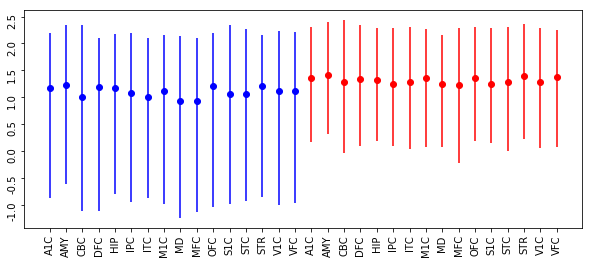

In [30]:
tpvals = []

for timepoint in timepoints:
    meds_case = []
    lows_case = []
    highs_case = []
    meds_ctrls = []
    lows_ctrls = []
    highs_ctrls = []

    positions_case=[]
    positions_ctrls=[]

    colors = []
    pos = 0
    
    pvals = []
    
    # Then controls
    for structure in structures:
        positions_ctrls.append(pos)
        colors.append("blue")
        pos += 1
        try:
            col = plotdata = coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M") &
                           (coldata["age"]==timepoint)]["column_num"].values[0]
        except:
            meds_ctrls.append(np.nan)
            lows_ctrls.append(np.nan)
            highs_ctrls.append(np.nan)
            continue
        expr_ctrls = np.log(brainspan.loc[genes_ctrls, col]+0.01)
        meds_ctrls.append(np.median(expr_ctrls))
        lows_ctrls.append(np.median(expr_ctrls)-np.percentile(expr_ctrls, q=25))
        highs_ctrls.append(np.percentile(expr_ctrls, q=75)-np.median(expr_ctrls))

    # First cases
    for structure in structures:
        positions_case.append(pos)
        colors.append("red")
        pos += 1
        try:
            col = plotdata = coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M") &
                           (coldata["age"]==timepoint)]["column_num"].values[0]
        except:
            meds_case.append(np.nan)
            lows_case.append(np.nan)
            highs_case.append(np.nan)
            continue
        expr_cases = np.log(brainspan.loc[genes_cases, col]+0.01)
        expr_ctrls = np.log(brainspan.loc[genes_ctrls, col]+0.01)

        meds_case.append(np.median(expr_cases))
        lows_case.append(np.median(expr_cases)-np.percentile(expr_cases, q=25))
        highs_case.append(np.percentile(expr_cases, q=75)-np.median(expr_cases))

        pvals.append(scipy.stats.mannwhitneyu(expr_cases, expr_ctrls, alternative="greater")[1])
        
    # Now plot
    fig = plt.figure()
    fig.set_size_inches((10, 4))
    ax = fig.add_subplot(111)
    ax.errorbar(positions_case, meds_case, fmt="o", color="red", yerr=[lows_case, highs_case])
    ax.errorbar(positions_ctrls, meds_ctrls, fmt="o", color="blue", yerr=[lows_ctrls, highs_ctrls])
    ax.set_xticks(positions_case+positions_ctrls)
    ax.set_xticklabels(structures*2, rotation=90)
    ax.set_yticklabels(ax.get_yticks(), rotation=90)
    fig.savefig("pdfs/Figure4_lineplot_%s.pdf"%timepoint)

    # Get fisher p-value
    print(timepoint)
    print(scipy.stats.combine_pvalues(pvals))
    tpvals.append(scipy.stats.combine_pvalues(pvals)[1])


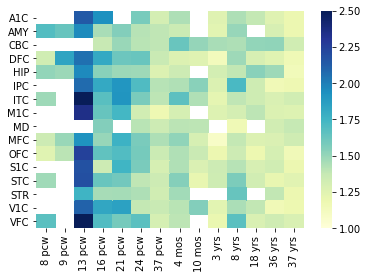

In [31]:
# Plot heatmap of fold change
fig = plt.figure()
ax = fig.add_subplot(111)
hm = sns.heatmap(fcdata,  xticklabels=timepoints, yticklabels=structures, ax=ax,  cmap="YlGnBu",
                vmin=1.0, vmax=2.5)
fig.savefig("pdfs/Figure4_FC_heatmap.pdf")

Adipose-Subcutaneous
MannwhitneyuResult(statistic=6904430.0, pvalue=0.565605998082075)
0.32904001900943824
3772
3669
Adipose-Visceral
MannwhitneyuResult(statistic=6805140.0, pvalue=0.5214270160267102)
0.3393922657203927
3749
3633
Artery-Aorta
MannwhitneyuResult(statistic=6861361.0, pvalue=0.07325716821532277)
0.44578397381757073
3717
3621
Artery-Tibial
MannwhitneyuResult(statistic=6886919.0, pvalue=0.13098748230596313)
0.3473560378358256
3737
3631
Brain-Caudate
MannwhitneyuResult(statistic=6757475.0, pvalue=0.036798625593176426)
0.04438870112766799
3693
3573
Brain-Cerebellum
MannwhitneyuResult(statistic=6502222.0, pvalue=0.5279460503013577)
0.42598985215481044
3675
3542
Cells-Transformedfibroblasts
MannwhitneyuResult(statistic=6397007.0, pvalue=0.42797584127514726)
0.36490019221649983
3636
3510
Esophagus-Mucosa
MannwhitneyuResult(statistic=6861993.0, pvalue=0.30062318639049257)
0.2221792779580643
3743
3641
Esophagus-Muscularis
MannwhitneyuResult(statistic=6857995.0, pvalue=0.7064805904

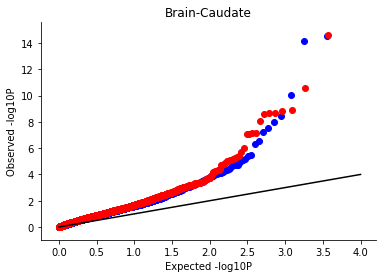

In [32]:
# Load gtex data
# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
def concat(x):
    return ",".join(x)

TISSUES=["Adipose-Subcutaneous",
         "Adipose-Visceral",
         "Artery-Aorta",
         "Artery-Tibial",
         "Brain-Caudate",
         "Brain-Cerebellum",
         "Cells-Transformedfibroblasts",
         "Esophagus-Mucosa",
         "Esophagus-Muscularis",
         "Heart-LeftVentricle",
         "Lung", 
         "Muscle-Skeletal", 
         "Nerve-Tibial",
         "Skin-NotSunExposed",
         "Skin-SunExposed", 
         "Thyroid",
         "WholeBlood"]

pvals = []

def GetXvals(size):
    # Get quantiles of uniform 0,1
    # return sorted -1*log10
    step = 1.0/size
    vals = np.array([step*(i+1) for i in range(size)])
    return -1*np.log10(vals)
    
for tissue in TISSUES:
    print(tissue)
    GTEXFILE = "/storage/mgymrek/gtex-estrs/revision/mastertables/%s_master.tab"%tissue
    gtex = pd.read_csv(GTEXFILE, sep="\t")
    gtex["chrom"] = gtex["chrom"].apply(lambda x: GetChrom(x))
    gtex["pos_hg19"] = gtex["str.start"].apply(int)
    gtex = gtex[~np.isnan(gtex["linreg.pval"])]
    gtex["linreg.beta"] = gtex["linreg.beta"].apply(abs)
    gtex = gtex.groupby(["chrom","pos_hg19","str.motif.forward"], as_index=False).agg({"linreg.pval": np.min, "linreg.beta": np.max, "gene.name": concat})

    merged = pd.merge(gtex, data, on=["chrom","pos_hg19"])
    #merged = merged[merged["str.motif.forward"].apply(len)>1]

    aff_pvals = -1*np.log10(sorted(list(merged[(merged["mut_aff"]>0) & (merged["mut_unaff"]==0)].sort_values("linreg.pval")["linreg.pval"])))
    unaff_pvals = -1*np.log10(sorted(list(merged[(merged["mut_unaff"]>0)& (merged["mut_aff"]==0)].sort_values("linreg.pval")["linreg.pval"])))

    print(scipy.stats.mannwhitneyu(aff_pvals, unaff_pvals, alternative="greater"))
    print(scipy.stats.ttest_ind(aff_pvals, unaff_pvals)[1]/2)
          
    print(len(aff_pvals))
    print(len(unaff_pvals))
    pvals.append(scipy.stats.mannwhitneyu(aff_pvals, unaff_pvals, alternative="greater")[1])
    if tissue == "Brain-Caudate":
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(GetXvals(len(unaff_pvals)), unaff_pvals, color="blue")
        ax.scatter(GetXvals(len(aff_pvals)), aff_pvals, color="red")
        ax.plot([0,4],[0,4], color="black")
        ax.set_title(tissue)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom');
        ax.set_xlabel("Expected -log10P")
        ax.set_ylabel("Observed -log10P")
        fig.savefig(os.path.join(OUTDIR, "Figure4_eSTR_QQ_%s.pdf"%tissue))